In [34]:

import tensorflow as tf
import os
from tensorflow import keras
tf.random.set_seed(1)

VERSION = '6'
OUTPUT_DIR = "v"+VERSION+"_fer2013_OUTPUT"
SAVE_IMGS = True

os.makedirs(OUTPUT_DIR, exist_ok=True)
print(OUTPUT_DIR)
print("Mevcut kullanılabilir GPU adedi : ", len(tf.config.list_physical_devices('GPU')))

v5_fer2013_OUTPUT
Mevcut kullanılabilir GPU adedi :  1


In [6]:
import os
import tqdm

# Run through fer2013 dataset
TEST_DIR= ".\\fer2013\\test"
TRAIN_DIR = ".\\fer2013\\train"

TRAIN_IMAGES = []
TEST_IMAGES = []

for emotion_dir in tqdm.tqdm(os.listdir(TRAIN_DIR)):
    
    for image in os.listdir(os.path.join(TRAIN_DIR, emotion_dir)):
        
        img = keras.preprocessing.image.load_img(os.path.join(TRAIN_DIR, emotion_dir, image),color_mode="grayscale")
        img = keras.preprocessing.image.img_to_array(img)
        TRAIN_IMAGES.append(img)

for emotion_dir in tqdm.tqdm(os.listdir(TEST_DIR)):
    
    for image in os.listdir(os.path.join(TEST_DIR, emotion_dir)):
        
        img = keras.preprocessing.image.load_img(os.path.join(TEST_DIR, emotion_dir, image),color_mode="grayscale")
        img = keras.preprocessing.image.img_to_array(img)
        
        TEST_IMAGES.append(img)




100%|██████████| 7/7 [00:32<00:00,  4.71s/it]


In [7]:
import numpy as np

#print train shape 
print("Train shape : ", np.array(TRAIN_IMAGES).shape)
print("Test shape : ", np.array(TEST_IMAGES).shape)

ALL_IMAGES = np.concatenate([TRAIN_IMAGES, TEST_IMAGES])
print("All images shape : ", ALL_IMAGES.shape)

Train shape :  (28709, 48, 48, 1)
Test shape :  (7178, 48, 48, 1)
All images shape :  (35887, 48, 48, 1)


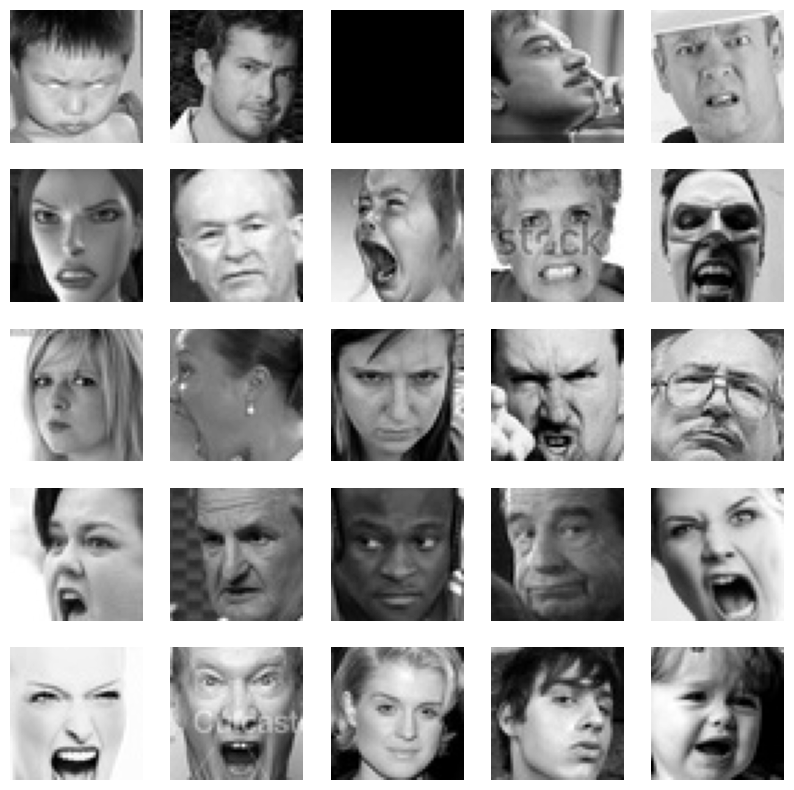

In [8]:
#plot first 25 images as image
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(ALL_IMAGES[i].reshape(48,48),cmap='gray')
    plt.axis('off')
plt.show()


In [9]:
import numpy as np
from skimage.color import rgb2gray

#merge the training and testing sets
dataset = ALL_IMAGES
#normalize the images 0 - 255 -> 0 - 1
dataset= (dataset.astype("float32")-127.5)/127.5
print(dataset.shape)
#3 kanal yerine -> 1 kanal
# dataset = rgb2gray(dataset)
# print(dataset.shape)
#reshape the images
# dataset = dataset.reshape(-1, 32, 32, 1)
# print(dataset.shape)
print(dataset[0])

(35887, 48, 48, 1)
[[[-0.60784316]
  [-0.7490196 ]
  [-0.88235295]
  ...
  [ 0.04313726]
  [ 0.18431373]
  [-0.3254902 ]]

 [[-0.5529412 ]
  [-0.73333335]
  [-0.827451  ]
  ...
  [ 0.08235294]
  [ 0.18431373]
  [-0.3019608 ]]

 [[-0.52156866]
  [-0.7647059 ]
  [-0.8117647 ]
  ...
  [ 0.11372549]
  [ 0.16862746]
  [-0.3019608 ]]

 ...

 [[-0.19215687]
  [-0.21568628]
  [-0.21568628]
  ...
  [ 0.16862746]
  [-0.18431373]
  [-0.33333334]]

 [[-0.16078432]
  [-0.12941177]
  [-0.11372549]
  ...
  [ 0.18431373]
  [-0.05882353]
  [-0.3254902 ]]

 [[-0.18431373]
  [-0.18431373]
  [-0.12156863]
  ...
  [ 0.12156863]
  [ 0.06666667]
  [-0.34901962]]]


In [10]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from keras import layers
import time

from IPython import display

In [11]:
BATCH_SIZE = 64

print("Datasetin boyutu : ", dataset.shape)

dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(60000).batch(BATCH_SIZE)
dataset


Datasetin boyutu :  (35887, 48, 48, 1)


<BatchDataset element_spec=TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name=None)>

In [12]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(1024,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(3, 3), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 48, 48, 1)

    return model

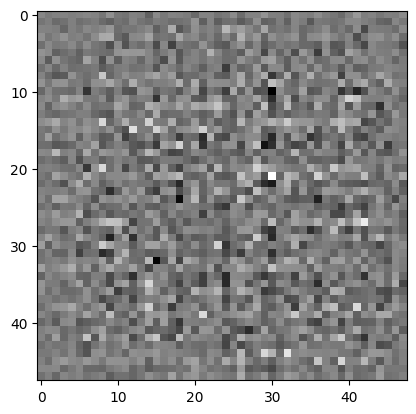

In [13]:
generator = make_generator_model()

noise = tf.random.normal([1, 1024])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [14]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[48, 48, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [15]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00040581]], shape=(1, 1), dtype=float32)


In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [17]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [18]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [20]:
# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
#                                  discriminator_optimizer=discriminator_optimizer,
#                                  generator=generator,
#                                  discriminator=discriminator)

In [37]:
EPOCHS = 20
noise_dim = 1024
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [38]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return {
        "gen_loss": gen_loss,
        "disc_loss": disc_loss,
        "gen_acc": tf.reduce_mean(tf.cast(fake_output > 0, tf.float32)),
        "disc_acc": (tf.reduce_mean(tf.cast(real_output > 0, tf.float32)) + tf.reduce_mean(tf.cast(fake_output < 0, tf.float32)) ) / 2,
    }

In [39]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  if SAVE_IMGS:
     plt.savefig(OUTPUT_DIR+'/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [40]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    gen_acc_arr = []
    disc_acc_arr = []
    gen_loss_arr = []
    disc_loss_arr = []
    for image_batch in dataset:
      res = train_step(image_batch)
      gen_acc_arr.append(res["gen_acc"])
      disc_acc_arr.append(res["disc_acc"])
      gen_loss_arr.append(res["gen_loss"])
      disc_loss_arr.append(res["disc_loss"])
    # Produce images for the GIF as you go
    # display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    print ('Epoch {}: gen_loss: {:.4f}, disc_loss: {:.4f}, gen_acc: {:.4f}, disc_acc: {:.4f}'.format(epoch + 1,
                                                                                                      np.mean(gen_loss_arr),
                                                                                                      np.mean(disc_loss_arr),
                                                                                                      np.mean(gen_acc_arr),
                                                                                                      np.mean(disc_acc_arr)))

    # Save the model every 15 epochs
    # if (epoch + 1) % 15 == 0:
    #   checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  # display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

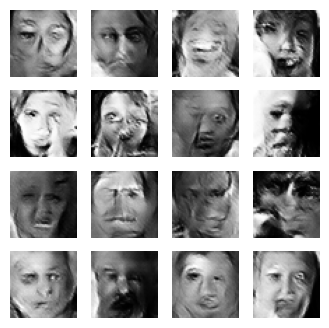

Epoch 1: gen_loss: 0.9999, disc_loss: 1.2525, gen_acc: 0.3272, disc_acc: 0.6564
Time for epoch 1 is 8.779963493347168 sec


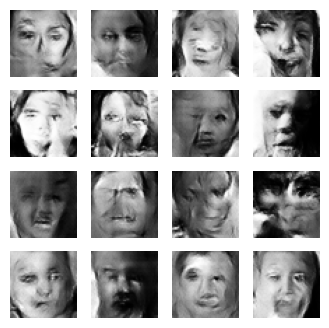

Epoch 2: gen_loss: 1.0360, disc_loss: 1.2056, gen_acc: 0.3072, disc_acc: 0.6728
Time for epoch 2 is 8.303846597671509 sec


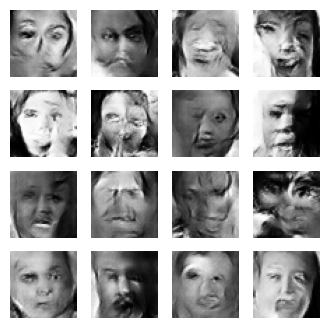

Epoch 3: gen_loss: 0.9873, disc_loss: 1.2371, gen_acc: 0.3170, disc_acc: 0.6589
Time for epoch 3 is 8.43321180343628 sec


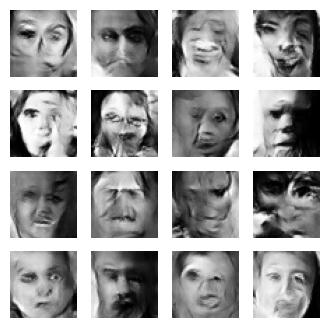

Epoch 4: gen_loss: 0.9773, disc_loss: 1.2279, gen_acc: 0.3133, disc_acc: 0.6627
Time for epoch 4 is 8.28759217262268 sec


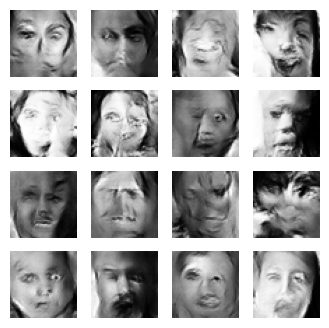

Epoch 5: gen_loss: 0.9815, disc_loss: 1.2336, gen_acc: 0.3165, disc_acc: 0.6601
Time for epoch 5 is 8.385552883148193 sec


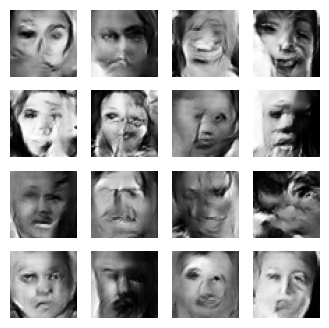

Epoch 6: gen_loss: 0.9755, disc_loss: 1.2263, gen_acc: 0.3150, disc_acc: 0.6613
Time for epoch 6 is 8.386195659637451 sec


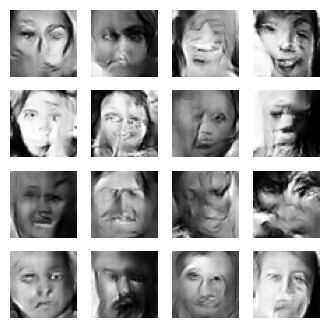

Epoch 7: gen_loss: 0.9576, disc_loss: 1.2372, gen_acc: 0.3219, disc_acc: 0.6546
Time for epoch 7 is 8.567496061325073 sec


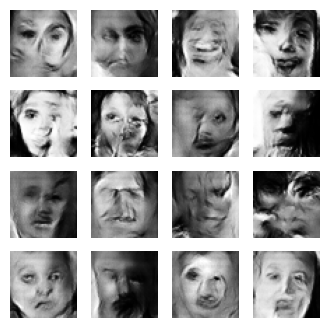

Epoch 8: gen_loss: 0.9640, disc_loss: 1.2341, gen_acc: 0.3197, disc_acc: 0.6565
Time for epoch 8 is 8.384664297103882 sec


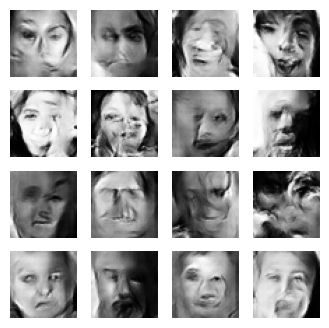

Epoch 9: gen_loss: 0.9654, disc_loss: 1.2407, gen_acc: 0.3221, disc_acc: 0.6536
Time for epoch 9 is 8.371165752410889 sec


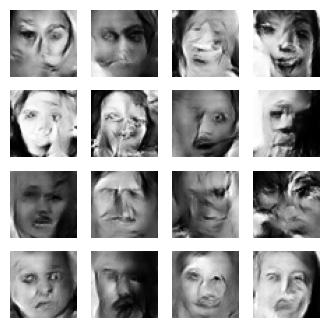

Epoch 10: gen_loss: 0.9518, disc_loss: 1.2373, gen_acc: 0.3215, disc_acc: 0.6560
Time for epoch 10 is 8.491881370544434 sec


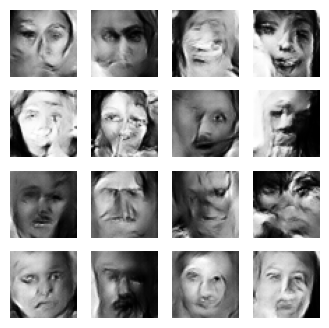

Epoch 11: gen_loss: 0.9389, disc_loss: 1.2456, gen_acc: 0.3215, disc_acc: 0.6523
Time for epoch 11 is 8.299027919769287 sec


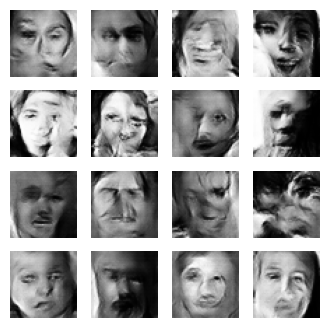

Epoch 12: gen_loss: 0.9306, disc_loss: 1.2536, gen_acc: 0.3307, disc_acc: 0.6468
Time for epoch 12 is 8.312442541122437 sec


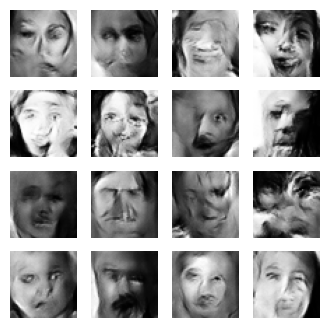

Epoch 13: gen_loss: 0.9586, disc_loss: 1.2452, gen_acc: 0.3231, disc_acc: 0.6542
Time for epoch 13 is 8.396391868591309 sec


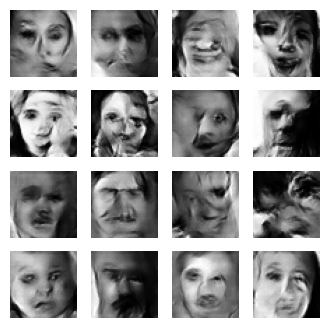

Epoch 14: gen_loss: 0.9367, disc_loss: 1.2367, gen_acc: 0.3208, disc_acc: 0.6556
Time for epoch 14 is 8.64412236213684 sec


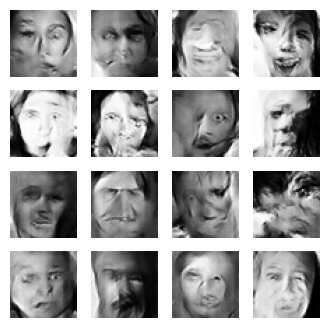

Epoch 15: gen_loss: 0.9436, disc_loss: 1.2478, gen_acc: 0.3225, disc_acc: 0.6527
Time for epoch 15 is 9.087883234024048 sec


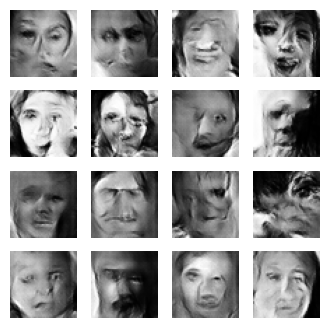

Epoch 16: gen_loss: 0.9344, disc_loss: 1.2494, gen_acc: 0.3277, disc_acc: 0.6488
Time for epoch 16 is 8.368812084197998 sec


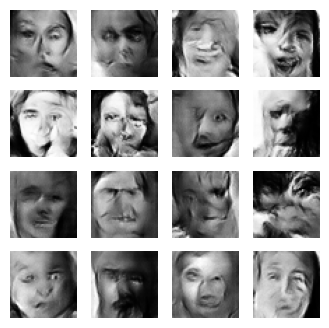

Epoch 17: gen_loss: 0.9279, disc_loss: 1.2460, gen_acc: 0.3259, disc_acc: 0.6490
Time for epoch 17 is 8.38618278503418 sec


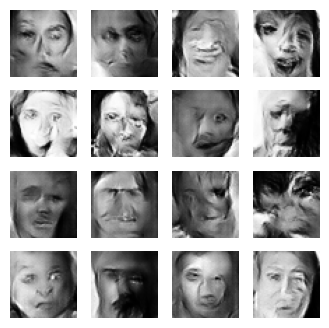

Epoch 18: gen_loss: 0.9337, disc_loss: 1.2485, gen_acc: 0.3273, disc_acc: 0.6495
Time for epoch 18 is 8.578871965408325 sec


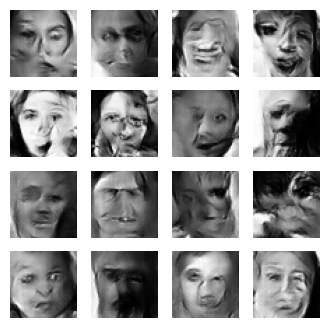

Epoch 19: gen_loss: 0.9157, disc_loss: 1.2537, gen_acc: 0.3302, disc_acc: 0.6459
Time for epoch 19 is 8.372229814529419 sec


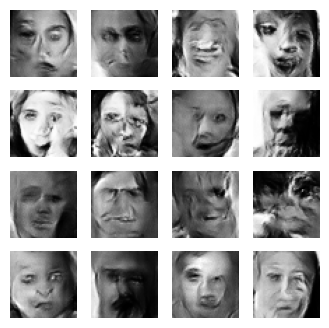

Epoch 20: gen_loss: 0.9279, disc_loss: 1.2511, gen_acc: 0.3273, disc_acc: 0.6499
Time for epoch 20 is 8.345857858657837 sec


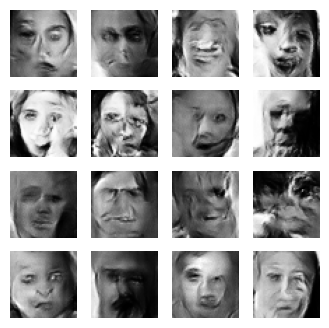

In [42]:
train(dataset, EPOCHS)